<a href="https://colab.research.google.com/github/SteveCara/TrafficSignClassifier/blob/master/TrafficLightClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import cv2

import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D
from keras.optimizers import Adam


In [ ]:
# clone repo containing the traffic sign dataset
!git clone https://bitbucket.org/jadslim/german-traffic-signs


fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [ ]:
# list dataset contents
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
# load the dataset
data = pd.read_csv('german-traffic-signs/signnames.csv')

In [ ]:
# load pickled dataset

with open("german-traffic-signs/train.p", mode='rb') as training:
  train = pickle.load(training)

with open("german-traffic-signs/valid.p", mode='rb') as validation:
  valid = pickle.load(validation)

with open("german-traffic-signs/test.p", mode = 'rb') as testing:
  test = pickle.load(testing)

In [ ]:
# set train, test, validation data (nb. I think if data not preprocessed, would likely neeed a train_test_split function)
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [ ]:
# view the shapes of each variable (num images, width=32 pixels, height=32 pixels, 3=coloured images)
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


image label=16


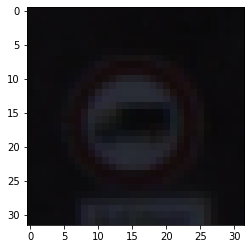

In [ ]:
# select random number to index and view a randomly selected image from the dataset
index = np.random.randint(1,len(X_train))

# use matplotlib to view image
plt.imshow(X_train[index])
print("image label={}".format(y_train[index]))

# **Image Pre-processing**

# 1. Convert to grayscale
# 2. Histogram equalisation
# 3. Normalisation

In [ ]:
# shuffle the data (don't want algorithm to learn the order of the data)
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [ ]:
# use CV2 to convert to grayscale
def preprocessing(img):
  
  # convert to grayscale
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  # apply histogram equalisation to standardise lighting in all images
  img = cv2.equalizeHist(img)

  # normalise the pixel values between 0 and 1 by dividing by 255
  img = img/255

  return img


In [ ]:
# apply pre-processing to all images

X_train_processed = np.array(list(map(preprocessing,X_train)))
X_validation_processed = np.array(list(map(preprocessing, X_validation)))
X_test_processed = np.array(list(map(preprocessing,X_test)))


In [ ]:
# reshape the array to feed into the models (as with shape this is (num images, width pixels, height pixels, num channels))
# as now the images are grayscale

X_train_processed = X_train_processed.reshape(34799,32,32,1)
X_test_processed = X_test_processed.reshape(12630,32,32,1)
X_validation_processed = X_validation_processed.reshape(4410,32,32,1)

In [ ]:
print(X_train_processed.shape)
print(X_test_processed.shape)
print(X_validation_processed.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


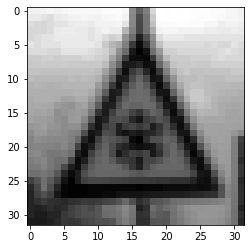

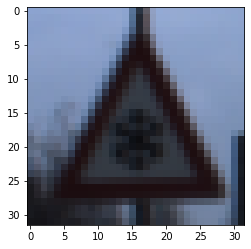

In [ ]:
# select random images from pre-processed data and non-processed data to compare
i = random.randint(1, len(X_train))


# select from processed (set cmap as grey as colour is actually teal & yellow)
plt.imshow(X_train_processed[i].squeeze(),cmap='gray')
plt.figure()

# select from non-processed
plt.imshow(X_train[i].squeeze())



In [ ]:
# build deep convolutional neural network model (sequential)
model = Sequential()

# add the convolutional layer
# filters (num. features extracted), size of filters (every 5x5 pixels), activation function, input shape
model.add(Conv2D(32,(5,5), activation='relu', input_shape=(32,32,1)))

# pooling layer (downscales the image as there is lots of data, only need features we need)
model.add(MaxPooling2D(pool_size=(2,2)))

# place a dropout layer (drop out 25% of neurals to avoid overfitting)
model.add(Dropout(0.25))

# add another convolutional layer (same as above but increased size of feature extraction from 32 to 64)
model.add(Conv2D(64,(5,5),activation='relu'))

# pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# flatten the image to 1d array
model.add(Flatten())

# add a dense layer: amount of nodes (neurons), activation
model.add(Dense(256, activation='relu'))

# place a dropout layer
# 0.5 drop out rate is recommended, half input nodes will be dropped at each update
model.add(Dropout(0.5))

# defining the output layer of our network (set as 43 classes as 43 types of sign)
model.add(Dense(43, activation='softmax'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

In [ ]:
# compile the model: optimiser (Adam), learning rate, loss type, metrics    
# for loss type 43 different classes (types of sign) so sp_cat_crossent if 2 classes then binary_crossent used  

model.compile(Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit the model
history = model.fit(X_train_processed,
                    y_train,
                    batch_size=500,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_validation_processed,y_validation))

Epoch 1/50
70/70 [==============================] - 2s 28ms/step - loss: 0.1998 - accuracy: 0.9413 - val_loss: 0.2375 - val_accuracy: 0.9304
Epoch 2/50
70/70 [==============================] - 2s 25ms/step - loss: 0.1900 - accuracy: 0.9435 - val_loss: 0.2396 - val_accuracy: 0.9261
Epoch 3/50
70/70 [==============================] - 2s 25ms/step - loss: 0.1843 - accuracy: 0.9448 - val_loss: 0.2349 - val_accuracy: 0.9283
Epoch 4/50
70/70 [==============================] - 2s 25ms/step - loss: 0.1804 - accuracy: 0.9463 - val_loss: 0.2314 - val_accuracy: 0.9290
Epoch 5/50
70/70 [==============================] - 2s 25ms/step - loss: 0.1772 - accuracy: 0.9484 - val_loss: 0.2378 - val_accuracy: 0.9295
Epoch 6/50
70/70 [==============================] - 2s 25ms/step - loss: 0.1707 - accuracy: 0.9494 - val_loss: 0.2303 - val_accuracy: 0.9315
Epoch 7/50
70/70 [==============================] - 2s 25ms/step - loss: 0.1688 - accuracy: 0.9505 - val_loss: 0.2314 - val_accuracy: 0.9304
Epoch 8/50
70

In [ ]:
# evaluate the performance of the trained model
score = model.evaluate(X_test_processed, y_test)
print('Test Accuracy', score[1])


395/395 [==============================] - 1s 3ms/step - loss: 0.2688 - accuracy: 0.9318
Test Accuracy 0.9318289756774902


In [ ]:
# the history object has an attribute called history which is a dictionary containing the values of loss and metrics during training
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'epochs')

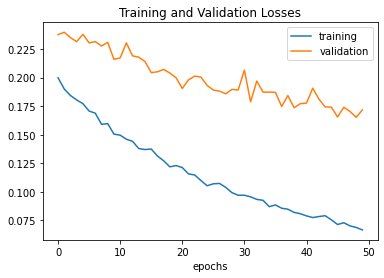

In [ ]:
# plot how the loss changes over time as the model is trained
# plot the training loss vs validation loss over the number of epochs

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Training and Validation Losses')
plt.xlabel('epochs')


Text(0.5, 0, 'epochs')

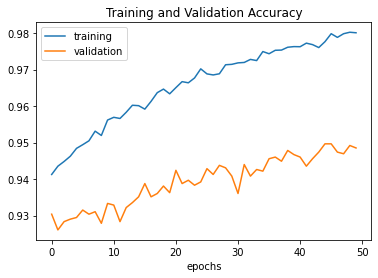

In [ ]:
# plot how the accuracy over time as the model is trained
# plot the accurcay vs validation accuracy over the number of epochs

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Training and Validation Accuracy')
plt.xlabel('epochs')


In [ ]:
# generate our predictions
prediction = model.predict_classes(X_test_processed)
y_true_label = y_test

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


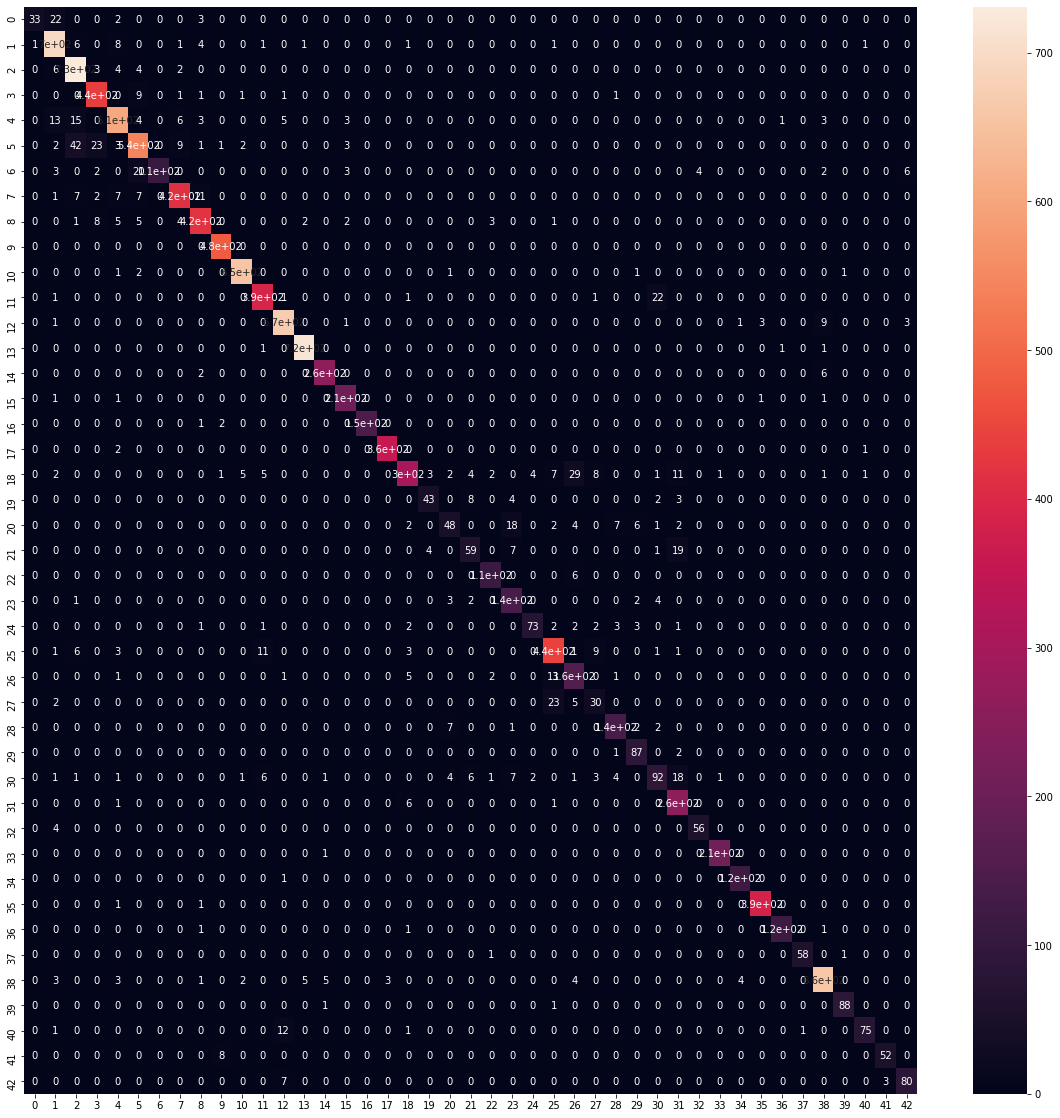

In [ ]:
# visualise the performance of the model in a matrix called confusion matrix (SC try replacing y_true_label with just y_test (see unnecessary step above))
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_true_label, prediction)

plt.figure(figsize=(20,20))
sns.heatmap(matrix,annot=True)

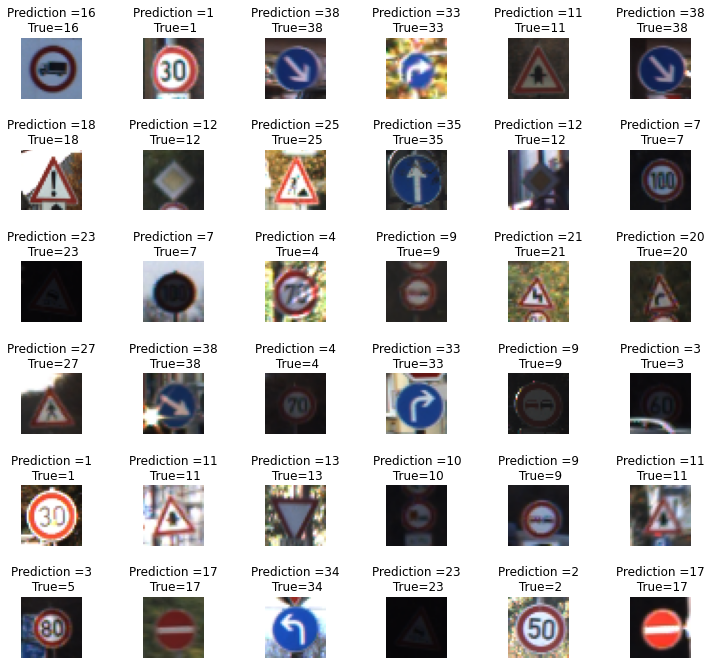

In [ ]:
# plot the predictions with labels
# create a 6 by 6 grid which contains 36 images with label and prediction

L = 6
W = 6
fig, axes = plt.subplots(L,W,figsize=(12,12))

# flatten matrix
axes = axes.ravel()

for i in range(0, L*W):
  axes[i].imshow(X_test[i])
  axes[i].set_title('Prediction ={}\n True={}'.format(prediction[i], y_true_label[i]))
  axes[i].axis('off')

plt.subplots_adjust(wspace=1)


In [ ]:
# save the model
model.save('my_model.h5')